In [1]:
import os
os.chdir('../')
%pwd

'/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction'

In [2]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingTimeseriesConfig:    
    root_dir: Path
    trained_od_timeseries_model_path: Path    
    base_od_timeseries_model_path: Path
    trained_tensor_timeseries_model_path: Path    
    base_tensor_timeseries_model_path: Path  
    trained_od_autoencoder_model_path: Path
    trained_tensor_autoencoder_model_path: Path   
    training_od_data: Path    
    training_tensor_data: Path    
    params_epochs: int
    params_batch_size: int   
    learning_rate: float
    validation_ratio: float
    params_time_lag: int

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    ckeckpoint_model_filepath: Path
    patience: int

In [3]:
from timeseriesPredictor.utils import read_yaml, create_directories
from timeseriesPredictor.constants import *

In [4]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_prepare_callbacks_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.ckeckpoint_model_filepath)

        create_directories([config.tensorboard_root_log_dir, model_ckpt_dir ])

        prepare_callbacks_config = PrepareCallbacksConfig(
           root_dir= config.root_dir,
           tensorboard_root_log_dir= config.tensorboard_root_log_dir,
           ckeckpoint_model_filepath=  config.ckeckpoint_model_filepath,
           patience = self.params.PATIENCE

        )

        return prepare_callbacks_config
    
    def get_timeseries_training_config(self) -> TrainingTimeseriesConfig:
        config= self.config.training_timeseries        
        
        create_directories([config.root_dir])

        training_timeseries_config = TrainingTimeseriesConfig(
        root_dir= config.root_dir,
        trained_od_timeseries_model_path= config.trained_od_timeseries_model_path, 
        base_od_timeseries_model_path = self.config.prepare_timeseries_base_model.base_od_timeseries_model_path,
        trained_tensor_timeseries_model_path= config.trained_tensor_timeseries_model_path, 
        base_tensor_timeseries_model_path = self.config.prepare_timeseries_base_model.base_tensor_timeseries_model_path,
        trained_od_autoencoder_model_path = self.config.training_autoencoder.trained_od_model_path, 
        trained_tensor_autoencoder_model_path = self.config.training_autoencoder.trained_tensor_model_path,
        training_od_data= self.config.data_transformation.local_train_od_dir,           
        training_tensor_data= self.config.data_transformation.local_train_tensor_dir,        
        params_epochs= self.params.EPOCHS, 
        params_batch_size= self.params.BATCH_SIZE,         
        learning_rate= self.params.LEARNING_RATE_TIMESERIES,
        validation_ratio= self.params.VALIDATION_RATIO,
        params_time_lag= self.params.TIME_LAG
        )

        return training_timeseries_config

In [5]:
from timeseriesPredictor.utils import model_loss, videos_frame_format
from timeseriesPredictor.logger import logging
import pickle
import keras

2023-08-18 19:39:04.780119: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 19:39:04.836171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 19:39:04.836865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 19:39:05.895013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
class TrainingTimeseries:
    def __init__(self, config: TrainingTimeseriesConfig):
        self.config= config

    @staticmethod
    def get_model(path:Path):
        model = keras.models.load_model(path)
        logging.info(f'Model is loaded from {path}!')
        return model  

    @staticmethod
    def load_pickle_file(path: Path):
        file= open(path, 'rb')
        obj = pickle.load(file)
        logging.info(f'Pickle file is loaded from {path}!')
        return obj
    
    @staticmethod
    def save_model(path:Path, model:keras.Model):        
        model.save(path)

    def data_preparation(self, data_path: Path, autoencoder_path: Path):
        data = self.load_pickle_file(data_path)
        autoencoder = self.get_model(autoencoder_path)
        encoderLayer = autoencoder.get_layer("encoder")
        encoder = keras.Model(
            autoencoder.input,
            encoderLayer.output
            )   
        encoded_data = encoder.predict(data)
        videos, next_frame = videos_frame_format(encoded_data, data, self.config.params_time_lag)        
        return  videos, next_frame


    def train(self, callback_list: list): 
        
        training_data_paths = [self.config.training_tensor_data, 
                               self.config.training_od_data]
        
        trained_autoencoder_model_paths = [self.config.trained_tensor_autoencoder_model_path,
                                            self.config.trained_od_autoencoder_model_path]
        
        base_timeseries_model_paths = [self.config.base_tensor_timeseries_model_path, 
                                       self.config.base_od_timeseries_model_path] 
        
        trained_timeseries_model_paths = [self.config.trained_tensor_timeseries_model_path, 
                                          self.config.trained_od_timeseries_model_path]       
        
        for data_path, autoencoder_path, base_model_path, trained_model_path in zip(training_data_paths, 
                                                                                    trained_autoencoder_model_paths, 
                                                                                    base_timeseries_model_paths, 
                                                                                    trained_timeseries_model_paths):
            
            videos, next_frame = self.data_preparation(data_path=data_path, autoencoder_path=autoencoder_path)

            model = self.get_model(base_model_path) 

            history = model.fit(videos, next_frame,
                validation_split=self.config.validation_ratio,           
                epochs= self.config.params_epochs,
                batch_size = self.config.params_batch_size,            
                callbacks = callback_list
                )
        
            model_loss(history)
            self.save_model(path=trained_model_path, model= model)
            logging.info(f'Trained timeseries model is saved at {trained_model_path}!')

In [7]:
import sys
from timeseriesPredictor.exception import CustomException
from timeseriesPredictor.components.prepare_callbacks import PrepareCallbacks 

20/20 [==============================] - 1s 20ms/step
Epoch 1/200
17/17 [==============================] - 25s 1s/step - loss: 0.1577 - MSE: 0.1577 - val_loss: 0.0212 - val_MSE: 0.0212
Epoch 2/200


/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 21s 1s/step - loss: 0.0457 - MSE: 0.0457 - val_loss: 0.0236 - val_MSE: 0.0236
Epoch 3/200
17/17 [==============================] - 23s 1s/step - loss: 0.0331 - MSE: 0.0331 - val_loss: 0.0309 - val_MSE: 0.0309
Epoch 4/200
17/17 [==============================] - 25s 1s/step - loss: 0.0303 - MSE: 0.0303 - val_loss: 0.0189 - val_MSE: 0.0189
Epoch 5/200
17/17 [==============================] - 38s 2s/step - loss: 0.0292 - MSE: 0.0292 - val_loss: 0.0200 - val_MSE: 0.0200
Epoch 6/200
17/17 [==============================] - 32s 2s/step - loss: 0.0286 - MSE: 0.0286 - val_loss: 0.0261 - val_MSE: 0.0261
Epoch 7/200
17/17 [==============================] - 24s 1s/step - loss: 0.0281 - MSE: 0.0281 - val_loss: 0.0216 - val_MSE: 0.0216
Epoch 8/200
17/17 [==============================] - 23s 1s/step - loss: 0.0279 - MSE: 0.0279 - val_loss: 0.0204 - val_MSE: 0.0204
Epoch 9/200
17/17 [==============================] - 25s 1s/step - loss: 0.0277 - MSE: 0.0277 -

/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction/src/timeseriesPredictor/utils.py:220: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


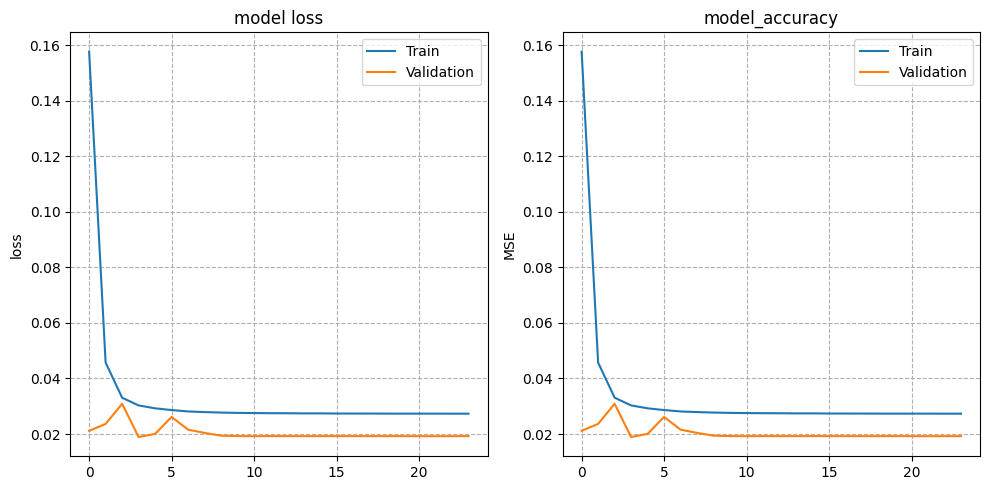

20/20 [==============================] - 0s 13ms/step
Epoch 1/200
17/17 [==============================] - 18s 858ms/step - loss: 0.1578 - MSE: 0.1578 - val_loss: 0.0316 - val_MSE: 0.0316
Epoch 2/200
17/17 [==============================] - 14s 834ms/step - loss: 0.0529 - MSE: 0.0529 - val_loss: 0.0298 - val_MSE: 0.0298
Epoch 3/200
17/17 [==============================] - 14s 838ms/step - loss: 0.0453 - MSE: 0.0453 - val_loss: 0.0286 - val_MSE: 0.0286
Epoch 4/200
17/17 [==============================] - 14s 851ms/step - loss: 0.0431 - MSE: 0.0431 - val_loss: 0.0277 - val_MSE: 0.0277
Epoch 5/200
17/17 [==============================] - 14s 835ms/step - loss: 0.0415 - MSE: 0.0415 - val_loss: 0.0272 - val_MSE: 0.0272
Epoch 6/200
17/17 [==============================] - 14s 834ms/step - loss: 0.0403 - MSE: 0.0403 - val_loss: 0.0268 - val_MSE: 0.0268
Epoch 7/200
17/17 [==============================] - 14s 828ms/step - loss: 0.0394 - MSE: 0.0394 - val_loss: 0.0267 - val_MSE: 0.0267
Epoch 8/

KeyboardInterrupt: 

In [8]:
try:
    config = configurationManeger()
    prepare_callbacks_config = config.get_prepare_callbacks_config()
    prepare_callbacks = PrepareCallbacks(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_es_callbacks()

    training_config = config.get_timeseries_training_config()
    training = TrainingTimeseries(config= training_config)   
    training.train(callback_list= callback_list)

except Exception as e:
    raise CustomException(e, sys)